<h1 style="font-size:3rem;color:orange;">Text sentiment analysis project</h1>

<h2>This is ML Canvas of the project, which defines the detailed pipeline of the project</h2>

<img src="ML Canvas.png">

## Step 0: Preparing Data, set up libraries, NLTK Basics

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import nltk

import opendatasets as od

od.download('https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews')

Skipping, found downloaded files in ".\amazon-fine-food-reviews" (use force=True to force download)


In [137]:
#Read in data
file = ('amazon-fine-food-reviews/\Reviews.csv')
df = pd.read_csv(file)
df = df.head(500)
print(df.shape)

(500, 10)


In [74]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Quick EDA

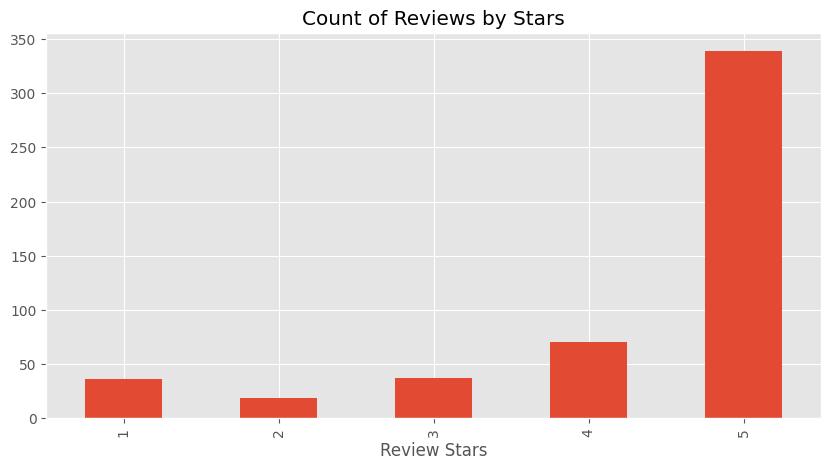

In [75]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews by Stars', figsize=(10, 5))

ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [76]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [77]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [78]:
#identify part of speech for each token
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [79]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1: VADER Sentiment Scoring

There will be examples of usiing VADER model, which gives results of neg/neu/pos/compaund sentiment of given text.

In [80]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [81]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [82]:
sia.polarity_scores('This is so awful!')

{'neg': 0.581, 'neu': 0.419, 'pos': 0.0, 'compound': -0.632}

In [83]:
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [84]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [138]:
# Run the polarity score on the entire dataset
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [86]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [87]:
# This shows sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot VADER results

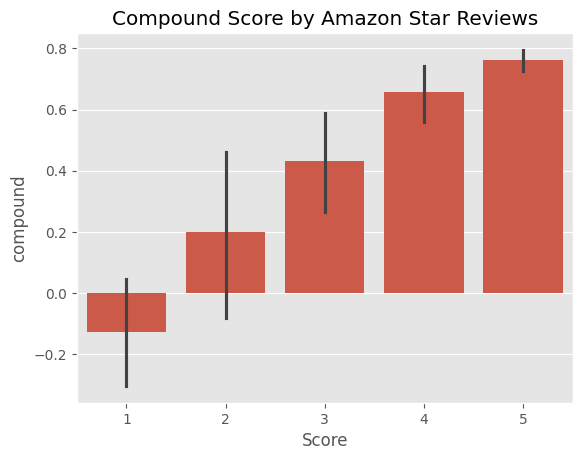

In [88]:
ax = sns.barplot(data = vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Reviews')
plt.show()

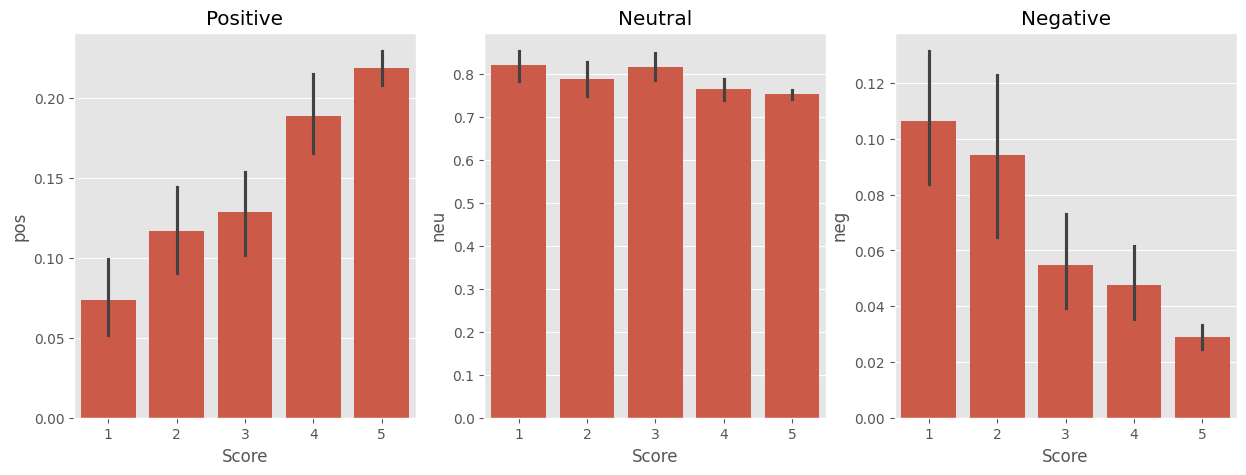

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

## Step 2: Use Pre-Trained RoBERTa model

In [90]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [95]:
model_name = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [96]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [97]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.97635514), 'roberta_neu': np.float32(0.020687466), 'roberta_pos': np.float32(0.0029573706)}


### Run model on GPU

In [119]:
# check the parametrs and what is used by PyTorch
import torch

# Проверяем, доступна ли CUDA
print("CUDA доступна:", torch.cuda.is_available())

# Проверяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Текущее устройство:", device)

# Проверяем имя GPU
if torch.cuda.is_available():
    print("Имя GPU:", torch.cuda.get_device_name(0))

CUDA доступна: True
Текущее устройство: cuda
Имя GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [116]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt').to(device)
    output = model(**encoded_text)
    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict
    

In [117]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_results = sia.polarity_scores(text)
        # rename VADER results into 'vader_neg/pos/neu'
        vader_results_rename = {}
        for key, value in vader_results.items():
            vader_results_rename[f"vader_{key}"] = value
        roberta_results = polarity_scores_roberta(text)
        
        both_results = {**vader_results_rename, **roberta_results}
        res[myid] = both_results
    except RuntimeError:
        print(f'Broke for id {myid}')
    

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


### Run model on CPU

In [120]:
device = 'cpu'
model = model.to(device)

In [121]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt').to(device)
    output = model(**encoded_text)
    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [122]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_results = sia.polarity_scores(text)
        # rename VADER results into 'vader_neg/pos/neu'
        vader_results_rename = {}
        for key, value in vader_results.items():
            vader_results_rename[f"vader_{key}"] = value
        roberta_results = polarity_scores_roberta(text)
        
        both_results = {**vader_results_rename, **roberta_results}
        res[myid] = both_results
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [126]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [127]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Step 3: Combine and compare results

In [129]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

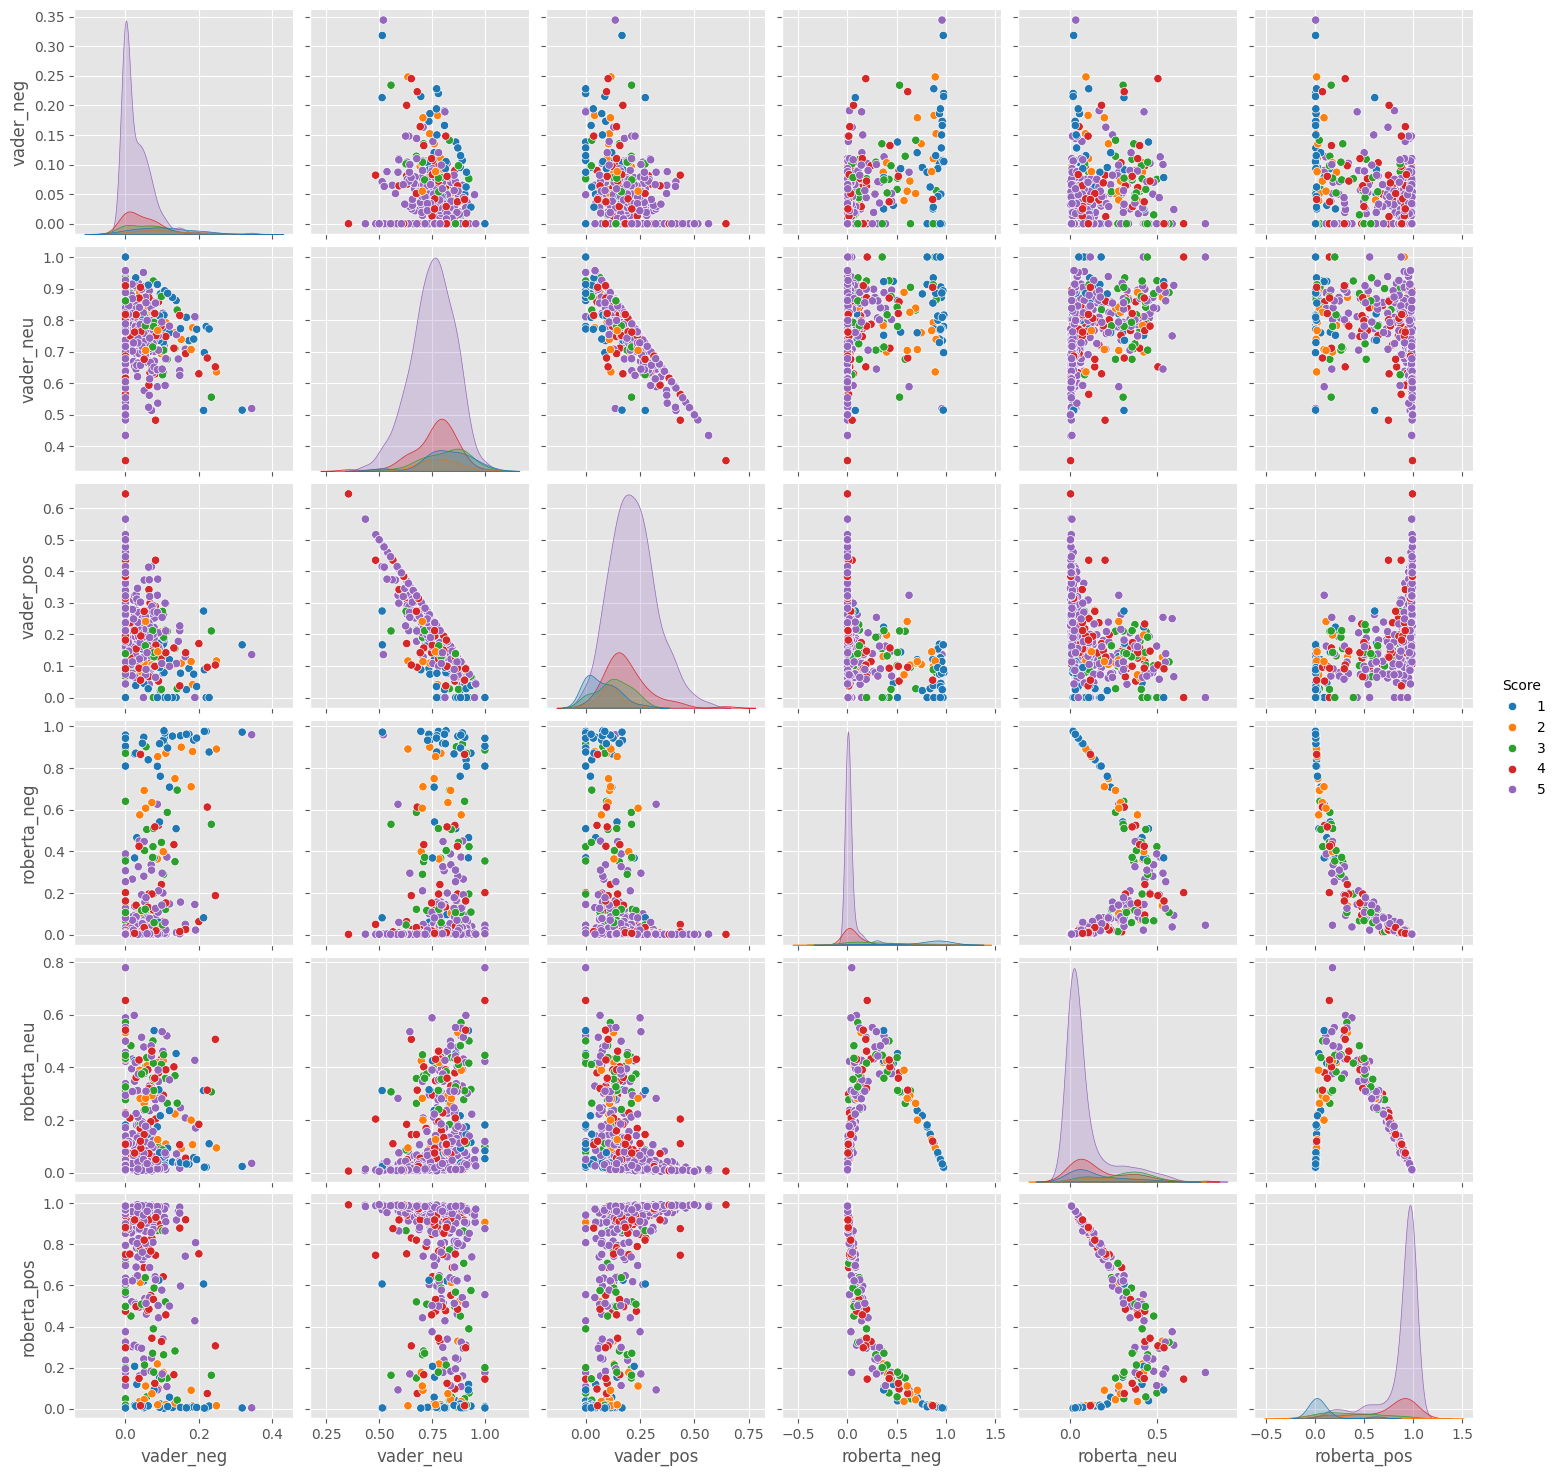

In [131]:
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos',
       'roberta_neg', 'roberta_neu', 'roberta_pos'], hue='Score', palette='tab10')
plt.show()

In [135]:
results_df.query("Score == 1").sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'